# Localization and object segmentation using CNN

In [1]:
# Import everything
import os
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import matplotlib.patches as mpatches
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.animation as animation

%matplotlib inline

In [2]:
# Set all defaults here
DATA_PATH = '../data/toy'
batch_size = 128

Работаем с игрушечным датасетом ``toy``. 
``toy/annotations`` содержит аннотации в формате pascal voc (обычный xml с определенными полями). Существует другой формат - COCO. Ниже код, который читает PASCAL VOC формат.

In [3]:
# загрузка аннотации картинки
def load_annotation(img_filename):
    xml = ""
    file = annotation_file_from_img(img_filename)
    if not os.path.exists(file): return None
    with open(file) as f:
        xml = f.readlines()
    xml = ''.join([line.strip('\t') for line in xml])
    return BeautifulSoup(xml, "html5lib")

# сделаем из имени файла имя файла аннотации
def annotation_file_from_img(img_name):
    return os.path.join(ANNOTATIONS, img_name) + '.xml'


# получить данные из файла аннотации
def load_data(images):        
        data = []
        for item in images:
            anno = load_annotation(item)
            if not anno: continue
            objs = anno.findAll('object')
            # в случае если объектов на картинке 
            # много, но это не про нас
            for obj in objs:
                obj_names = obj.findChildren('name')
                for name_tag in obj_names:
                    fname = anno.findChild('filename').contents[0]
                    fname = os.path.splitext(fname)[0] # удалим расширение
                    bbox = obj.findChildren('bndbox')[0]
                    xmin = int(bbox.findChildren('xmin')[0].contents[0])
                    ymin = int(bbox.findChildren('ymin')[0].contents[0])
                    xmax = int(bbox.findChildren('xmax')[0].contents[0])
                    ymax = int(bbox.findChildren('ymax')[0].contents[0])
                    data.append([fname, xmin, ymin, xmax, ymax])
        df = pd.DataFrame(
            data, columns=['fname', 'xmin', 'ymin', 'xmax', 'ymax'])
        df = df.set_index('fname')
        return df


In [5]:
ANNOTATIONS = DATA_PATH + '/annotations/'
IMAGES = DATA_PATH + '/images/'
image_files = [ os.path.splitext(f)[0] for f in os.listdir(IMAGES) if os.path.splitext(f)[1] == '.jpg'] 
data = load_data(image_files)
print ("Total images", len(data))
# data.head()

Total images 99


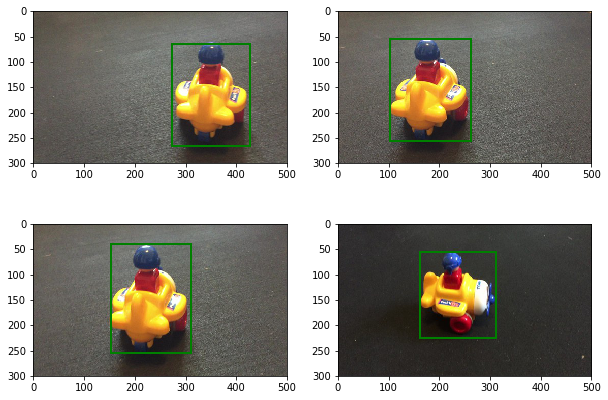

In [33]:
# Show some random data
size = 4
sample = np.random.choice(np.linspace(0, len(image_files)-1, len(image_files), dtype=int), replace=False, size=size)
plt.figure(figsize=(10, 15))
for num in range(1, size+1):
    #имя файла это индекс в датасете
    idx = image_files[sample[num-1]]    
    ax = plt.subplot(4,2,num)
    # читаем и показываем картинки 
    img = mpim.imread(os.path.join(IMAGES, idx + '.jpg'))
    ax.imshow(img)
    # задаем положение bb
    x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
    w, h = w - x, h-y
    rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

In [34]:
class Net(nn.Module):
    """
    Simple Net that classifies and predict bounding box coordinates
    """
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2)
                                 # ну и что то еще,
                                )
        # ....
        self.linear_input = None # размер финального слоя CNN -> count_features x out_W x out_H
        self.classes = nn.Linear(self.linear_input, 2) # два класса 
        self.bb      = nn.Linear(self.linear_input, 4) # координаты ограничивающего прямоугольника
#         nn.MSELoss() # реализует L2 лосс
    def forward(self, x):
        o = self.net(x)
        o = o.view(-1, self.linear_input)
        return self.classes(o), self.bb(o) # возвращаем два logit'а для оценки, при помощи nn.Softmax() и координаты

#### Функция потерь
$\large L =  \begin{cases}
   L_{mce} + L_{ce} + L_{bce}, & \text{if} \ p_c = 1 \\
   L_{bce}, & \text{if} \ p_c = 0 
   \end{cases}
$

$L_{mse} $ - MSE по координатам bounding box

$L_{ce}$ - кросс энтропия по объектам

$L_{bce}$ - бинарная кросс энтропия для детекции объекта на картинке